In [119]:
import yfinance as yh
from backtesting import *
from backtesting.lib import crossover, FractionalBacktest

In [75]:
btc_ticker = 'BTC-USD'


In [105]:
btc_yh = yh.Ticker(btc_ticker)
btc_hist = btc_yh.history(period='max', interval='1d')

In [106]:
def rsi_col(df, period=14, col_name="RSI"):
    delta = df["Close"].diff()

    gain = delta.where(delta > 0, 0.0)
    loss = -delta.where(delta < 0, 0.0)

    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    df[col_name] = rsi
    return df


In [107]:
def add_emas(df, span_short=50, span_long=200, price_col="Close",
             short_col="EMA_50", long_col="EMA_200"):
    """
    Add 50- and 200-period EMAs to the provided DataFrame (defaults).
    Returns the same DataFrame with two new columns.
    """
    df[short_col] = df[price_col].ewm(span=span_short, adjust=False).mean()
    df[long_col] = df[price_col].ewm(span=span_long, adjust=False).mean()
    return df

In [ ]:
import pandas as pd
import numpy as np
from backtesting import Strategy, Backtest
from backtesting.lib import crossover, FractionalBacktest

def RSI_Wilder(series, period=14):
    """Calculates RSI using Wilder's Smoothing Method (Standard)"""
    delta = series.diff()
    gain = (delta.where(delta > 0, 0))
    loss = (-delta.where(delta < 0, 0))
    
    # Use EWM for Wilder's Smoothing
    avg_gain = gain.ewm(alpha=1/period, adjust=False).mean()
    avg_loss = loss.ewm(alpha=1/period, adjust=False).mean()
    
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))



In [ ]:
class RSIStrategy(Strategy):
    oversold = 30
    overbought = 70

    def init(self):
        # We wrap the manual RSI function in self.I to make it compatible
        self.rsi = self.I(RSI_Wilder, self.data.Close.to_series(), 14)
        self.ema_short = self.I(lambda x: x.ewm(span=50, adjust=False).mean(), self.data.Close.to_series())
        self.ema_long = self.I(lambda x: x.ewm(span=200, adjust=False).mean(), self.data.Close.to_series())

    def next(self):
        # Trade logic using built-in crossover for reliability
        if not self.position:
            
            if crossover(self.rsi, self.oversold):
                # Uses 95% of cash to buy fractional BTC
                self.buy(size=0.95)
        
        elif crossover(self.overbought, self.rsi):
            # Exit position when overbought
            self.position.close()


In [124]:

# --- Data Preparation ---
# Ensure your columns are capitalized for backtesting.py
df_bt = btc_hist.copy()
df_bt.columns = [c.capitalize() for c in df_bt.columns]

# Check if index is datetime (required for backtesting)
df_bt.index = pd.to_datetime(df_bt.index)

# Initialize the Fractional Backtest
bt = FractionalBacktest(
    df_bt, 
    RSIStrategy, 
    cash=1000, 
    commission=.002
)

stats = bt.run()
print(stats)

Start                     2014-09-17 00:00:00
End                       2026-02-06 00:00:00
Duration                   4160 days 00:00:00
Exposure Time [%]                    39.05311
Equity Final [$]                   3640.56794
Equity Peak [$]                    5231.29541
Commissions [$]                     202.03041
Return [%]                          264.05679
Buy & Hold Return [%]             16329.44223
Return (Ann.) [%]                    12.00189
Volatility (Ann.) [%]                45.82949
CAGR [%]                             12.00494
Sharpe Ratio                          0.26188
Sortino Ratio                         0.45795
Calmar Ratio                          0.18301
Alpha [%]                         -5557.53921
Beta                                  0.35651
Max. Drawdown [%]                   -65.57903
Avg. Drawdown [%]                    -9.77272
Max. Drawdown Duration     2101 days 00:00:00
Avg. Drawdown Duration      148 days 00:00:00
# Trades                          

/Users/soliriusadmin211/Downloads/finance_app/.venv/lib/python3.11/site-packages/backtesting/_util.py:135: UserWarning: `.to_series()` is deprecated. For pd.Series conversion, use accessor `.s`
  warnings.warn("`.to_series()` is deprecated. For pd.Series conversion, use accessor `.s`")
/Users/soliriusadmin211/Downloads/finance_app/.venv/lib/python3.11/site-packages/backtesting/lib.py:548: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  result = super().run(**kwargs)


In [128]:
from datetime import datetime

btc_halvings = {
    1: {
        "date": datetime(2012, 11, 28),
        "reward_before": 50.0,
        "reward_after": 25.0,
        "price_usd": 12.35
    },
    2: {
        "date": datetime(2016, 7, 9),
        "reward_before": 25.0,
        "reward_after": 12.5,
        "price_usd": 650.63
    },
    3: {
        "date": datetime(2020, 5, 11),
        "reward_before": 12.5,
        "reward_after": 6.25,
        "price_usd": 8821.42
    },
    4: {
        "date": datetime(2024, 4, 20),
        "reward_before": 6.25,
        "reward_after": 3.125,
        "price_usd": 63850.00
    },
    5: {
        "date": datetime(2028, 4, 17), # Current 2026 estimate
        "reward_before": 3.125,
        "reward_after": 1.5625,
        "price_usd": None # Still in the future!
    }
}

In [129]:
results = []

# We iterate through the dictionary (excluding the future 5th halving)
for i in range(1, 5):
    start_date = btc_halvings[i]['date']
    
    # End search at next halving date or today's date
    end_date = btc_halvings[i+1]['date'] if i+1 in btc_halvings else btc_data.index[-1]
    
    # 1. Slice the DataFrame for this specific cycle
    cycle_data = btc_data.loc[start_date:end_date]
    
    if not cycle_data.empty:
        # 2. Find the peak price and the date it happened
        peak_price = cycle_data['Close'].max()
        peak_date = cycle_data['Close'].idxmax()
        
        # 3. Calculate the difference in days
        days_to_peak = (peak_date - start_date).days
        
        results.append({
            "Halving": i,
            "Halving Date": start_date.strftime('%Y-%m-%d'),
            "Peak Date": peak_date.strftime('%Y-%m-%d'),
            "Days to Peak": days_to_peak,
            "Multiplier": round(peak_price / btc_halvings[i]['price_usd'], 2)
        })

# Display as a DataFrame for easy reading
import pandas as pd
analysis_df = pd.DataFrame(results)
print(analysis_df)

   Halving Halving Date   Peak Date  Days to Peak  Multiplier
0        1   2012-11-28  2016-06-16          1296       62.05
1        2   2016-07-09  2017-12-16           525       29.97
2        3   2020-05-11  2024-03-13          1402        8.28
3        4   2024-04-20  2025-10-06           534        1.95


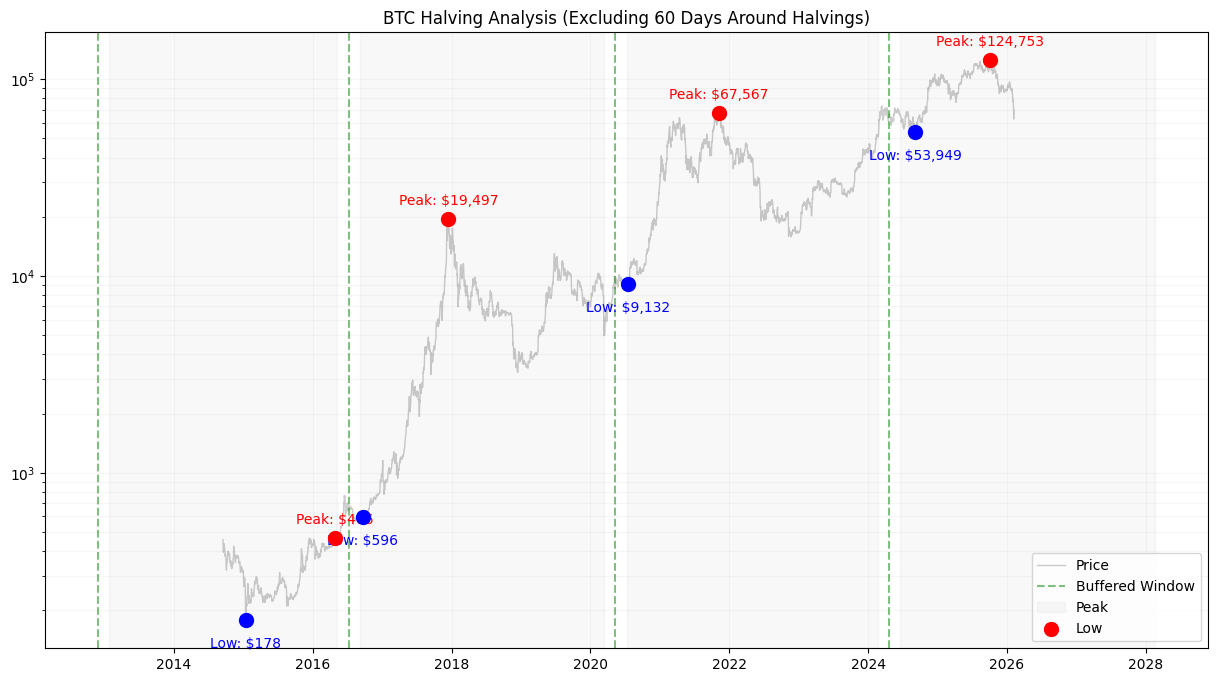

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

def plot_halving_with_buffer(df, halvings_dict, buffer_days=30):
    # Ensure index is datetime
    df.index = pd.to_datetime(df.index)
    plt.figure(figsize=(15, 8))
    
    # Plot the full price curve in the background
    plt.plot(df.index, df['Close'], color='black', alpha=0.2, label='BTC Price', linewidth=1)
    
    for i, h in halvings_dict.items():
        # Define the Halving Event Date
        h_date = h['date']
        
        # 1. Create the Buffer Window
        # Start search 30 days AFTER halving
        search_start = h_date + timedelta(days=buffer_days)
        
        # End search 30 days BEFORE the next halving
        if i + 1 in halvings_dict:
            search_end = halvings_dict[i+1]['date'] - timedelta(days=buffer_days)
        else:
            search_end = df.index[-1]
            
        # 2. Slice the Data for Analysis
        cycle_buffered = df.loc[search_start : search_end]
        
        if not cycle_buffered.empty:
            # Draw the actual Halving vertical line
            plt.axvline(h_date, color='green', linestyle='--', alpha=0.5)
            
            # Draw the "Search Window" shading to visualize the buffer
            plt.axvspan(search_start, search_end, color='gray', alpha=0.05)
            
            # --- Find Peak within the buffered window ---
            peak_idx = cycle_buffered['Close'].idxmax()
            peak_val = cycle_buffered['Close'].max()
            plt.scatter(peak_idx, peak_val, color='red', s=100, zorder=5)
            plt.annotate(f"Peak: ${peak_val:,.0f}", (peak_idx, peak_val), 
                         xytext=(0,10), textcoords='offset points', color='red', ha='center')
            
            # --- Find Low within the buffered window ---
            low_idx = cycle_buffered['Close'].idxmin()
            low_val = cycle_buffered['Close'].min()
            plt.scatter(low_idx, low_val, color='blue', s=100, zorder=5)
            plt.annotate(f"Low: ${low_val:,.0f}", (low_idx, low_val), 
                         xytext=(0,-20), textcoords='offset points', color='blue', ha='center')

    plt.yscale('log')
    plt.title(f"BTC Halving Analysis (Excluding {buffer_days} Days Around Halvings)")
    plt.legend(['Price', 'Buffered Window', 'Peak', 'Low'])
    plt.grid(True, which="both", alpha=0.1)
    plt.show()

# To run it:
plot_halving_with_buffer(btc_data, btc_halvings, buffer_days=60)

In [134]:
from datetime import timedelta
import pandas as pd

def get_buffered_cycle_analysis(df, halvings_dict, buffer_days=60):
    analysis_results = []
    
    for i in range(1, 5): # Iterate through Halvings 1 to 4
        h_date = halvings_dict[i]['date']
        
        # 1. Apply Buffer to Search Window
        search_start = h_date + timedelta(days=buffer_days)
        if i + 1 in halvings_dict:
            search_end = halvings_dict[i+1]['date'] - timedelta(days=buffer_days)
        else:
            search_end = df.index[-1]
            
        # Ensure window is within current data limits
        search_end = min(search_end, df.index[-1])
        cycle_slice = df.loc[search_start : search_end]
        
        if not cycle_slice.empty:
            # 2. Extract Peak Metrics
            peak_date = cycle_slice['Close'].idxmax()
            peak_price = cycle_slice['Close'].max()
            days_to_peak = (peak_date - h_date).days
            
            # 3. Extract Low Metrics (Searching ONLY after the peak)
            after_peak = cycle_slice.loc[peak_date:]
            if not after_peak.empty:
                low_date = after_peak['Close'].idxmin()
                low_price = after_peak['Close'].min()
                days_to_low = (low_date - h_date).days
                drawdown = ((low_price - peak_price) / peak_price) * 100
            else:
                low_date, low_price, days_to_low, drawdown = None, None, None, None

            # 4. Compile Row
            analysis_results.append({
                "Cycle": f"H{i} ({h_date.year})",
                "Halving Date": h_date.date(),
                "Peak Date": peak_date.date(),
                "Days to Peak": days_to_peak,
                "Peak Price": round(peak_price, 2),
                "Cycle Low Date": low_date.date() if low_date else "N/A",
                "Days to Low": days_to_low,
                "Low Price": round(low_price, 2) if low_price else "N/A",
                "Drawdown %": round(drawdown, 2) if drawdown else 0
            })

    return pd.DataFrame(analysis_results)

# Create the final analysis object
final_analysis_df = get_buffered_cycle_analysis(btc_data, btc_halvings)

# Display the results
print(final_analysis_df)

       Cycle Halving Date   Peak Date  Days to Peak  Peak Price  \
0  H1 (2012)   2012-11-28  2016-04-26          1245      466.09   
1  H2 (2016)   2016-07-09  2017-12-16           525    19497.40   
2  H3 (2020)   2020-05-11  2021-11-08           546    67566.83   
3  H4 (2024)   2024-04-20  2025-10-06           534   124752.53   

  Cycle Low Date  Days to Low  Low Price  Drawdown %  
0     2016-05-02         1251     444.67       -4.60  
1     2018-12-15          889    3236.76      -83.40  
2     2022-11-21          924   15787.28      -76.63  
3     2026-02-05          656   62702.10      -49.74  
